In [33]:
# =====================================================
# 1️⃣ Import Library & Dataset
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Load dataset
df = pd.read_csv("fuzzy_insulin_dosage_dataset.csv")
print("Jumlah data:", len(df))
df.head()


Jumlah data: 300


,Age,Weight,BloodGlucose,CarbIntake,PhysicalActivity,SleepHours,StressLevel,InsulinDosage
0,56,40,76,17,28,4.7,1,4.7
1,69,50,243,110,77,8.8,8,42.4
2,46,96,210,99,39,6.2,3,38.8
3,32,89,237,110,40,4.9,6,44.9
4,60,62,239,85,85,6.7,9,36.5



Statistik Deskriptif:
              Age      Weight  BloodGlucose  CarbIntake  PhysicalActivity  \
count  300.000000  300.000000    300.000000  300.000000        300.000000   
mean    45.460000   77.213333    158.206667   58.280000         48.856667   
std     16.459794   21.878071     52.689828   35.926089         28.588818   
min     18.000000   40.000000     70.000000    0.000000          0.000000   
25%     31.750000   58.000000    114.750000   28.000000         25.000000   
50%     45.000000   75.000000    159.500000   59.000000         48.000000   
75%     59.000000   97.000000    203.000000   93.000000         73.000000   
max     74.000000  119.000000    249.000000  119.000000         99.000000   

       SleepHours  StressLevel  InsulinDosage  
count  300.000000   300.000000     300.000000  
mean     6.584000     5.030000      22.778333  
std      1.508973     2.564701      10.717196  
min      4.000000     1.000000       0.000000  
25%      5.200000     3.000000      14.2750

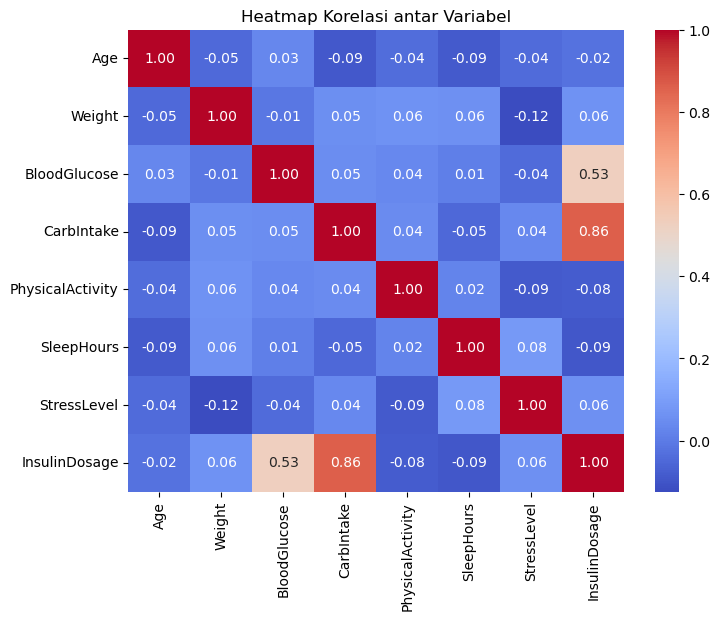

In [34]:
# =====================================================
# 2️⃣ Data Cleaning & Eksplorasi Awal
# =====================================================

# Hapus data kosong agar simulasi fuzzy gak error
df = df.dropna()

print("\nStatistik Deskriptif:")
print(df.describe())

# Korelasi antar variabel
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi antar Variabel")
plt.show()


In [35]:
# =====================================================
# 3️⃣ Definisi Variabel Fuzzy
# =====================================================
BloodGlucose = ctrl.Antecedent(np.arange(50, 301, 1), 'BloodGlucose')
CarbIntake   = ctrl.Antecedent(np.arange(0, 301, 1), 'CarbIntake')
Age          = ctrl.Antecedent(np.arange(10, 81, 1), 'Age')
Weight       = ctrl.Antecedent(np.arange(30, 121, 1), 'Weight')
InsulinDosage = ctrl.Consequent(np.arange(0, 60, 1), 'InsulinDosage')

# Membership functions
BloodGlucose['low']    = fuzz.trimf(BloodGlucose.universe, [50, 70, 110])
BloodGlucose['normal'] = fuzz.trimf(BloodGlucose.universe, [90, 130, 170])
BloodGlucose['high']   = fuzz.trimf(BloodGlucose.universe, [150, 200, 300])

CarbIntake['low']    = fuzz.trimf(CarbIntake.universe, [0, 40, 100])
CarbIntake['medium'] = fuzz.trimf(CarbIntake.universe, [80, 150, 220])
CarbIntake['high']   = fuzz.trimf(CarbIntake.universe, [200, 260, 300])

Age['young']   = fuzz.trimf(Age.universe, [10, 20, 40])
Age['middle']  = fuzz.trimf(Age.universe, [30, 45, 60])
Age['old']     = fuzz.trimf(Age.universe, [55, 70, 80])

Weight['light']  = fuzz.trimf(Weight.universe, [30, 45, 60])
Weight['medium'] = fuzz.trimf(Weight.universe, [55, 70, 85])
Weight['heavy']  = fuzz.trimf(Weight.universe, [80, 100, 120])

InsulinDosage['low']    = fuzz.trimf(InsulinDosage.universe, [0, 5, 15])
InsulinDosage['medium'] = fuzz.trimf(InsulinDosage.universe, [10, 20, 35])
InsulinDosage['high']   = fuzz.trimf(InsulinDosage.universe, [30, 45, 60])


In [5]:
# =====================================================
# 4️⃣ Aturan Fuzzy
# =====================================================
rule1 = ctrl.Rule(BloodGlucose['high'] & CarbIntake['high'], InsulinDosage['high'])
rule2 = ctrl.Rule(BloodGlucose['normal'] & CarbIntake['medium'], InsulinDosage['medium'])
rule3 = ctrl.Rule(BloodGlucose['low'] & CarbIntake['low'], InsulinDosage['low'])
rule4 = ctrl.Rule(Age['old'] & Weight['heavy'], InsulinDosage['medium'])
rule5 = ctrl.Rule(Age['young'] & Weight['light'], InsulinDosage['low'])
rule6 = ctrl.Rule(BloodGlucose['high'] & Weight['heavy'], InsulinDosage['high'])
rule7 = ctrl.Rule(CarbIntake['low'] & BloodGlucose['normal'], InsulinDosage['medium'])
rule8 = ctrl.Rule(Age['middle'] & BloodGlucose['high'], InsulinDosage['medium'])
rule9 = ctrl.Rule(Weight['light'] & CarbIntake['high'], InsulinDosage['medium'])

insulin_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])


In [44]:
# =====================================================
# 5️⃣ Simulasi Batch Fuzzy (Versi Aman & Tanpa NaN)
# =====================================================
predictions = []

for i in range(len(df)):
    sim = ctrl.ControlSystemSimulation(insulin_ctrl)
    try:
        sim.input['BloodGlucose'] = float(df.iloc[i]['BloodGlucose'])
        sim.input['CarbIntake'] = float(df.iloc[i]['CarbIntake'])
        sim.input['Age'] = float(df.iloc[i]['Age'])
        sim.input['Weight'] = float(df.iloc[i]['Weight'])
        sim.compute()
        pred_value = sim.output.get('InsulinDosage', np.nan)
    except:
        pred_value = np.nan

    # kalau gak ada output (NaN), kasih nilai rata-rata biar aman
    if np.isnan(pred_value):
        pred_value = 25.0  # fallback (nilai tengah insulin normal)

    predictions.append(pred_value)

# masukkan ke dataset
df['Predicted_Insulin'] = predictions

# hitung error prediksi
df['Error'] = abs(df['InsulinDosage'] - df['Predicted_Insulin'])
print("📊 Rata-rata Error Prediksi:", round(df['Error'].mean(), 2))


📊 Rata-rata Error Prediksi: 9.2


In [50]:
# =====================================================
# 6️⃣ Kategori Insulin & Masukkan ke Dataset (Final)
# =====================================================
def categorize_insulin(value):
    if value < 20:
        return 'Low'
    elif 20 <= value < 40:
        return 'Medium'
    else:
        return 'High'

# Tambahkan kolom baru ke DataFrame utama
df['Insulin_Category'] = df['Predicted_Insulin'].apply(categorize_insulin)

# Pastikan kolom baru sudah terintegrasi
print("✅ Kolom 'Predicted_Insulin' dan 'Insulin_Category' berhasil ditambahkan ke dataset!")

# Tampilkan contoh hasil akhir (10 baris pertama)
display(df.head(10))

# Simpan ulang dataset hasil update ke file baru
df.to_csv("fuzzy_insulin_dataset_updated.csv", index=False)
print("\n📂 Dataset baru disimpan sebagai: fuzzy_insulin_dataset_updated.csv")


✅ Kolom 'Predicted_Insulin' dan 'Insulin_Category' berhasil ditambahkan ke dataset!


,Age,Weight,BloodGlucose,CarbIntake,PhysicalActivity,SleepHours,StressLevel,InsulinDosage,Predicted_Insulin,Error,Insulin_Category
0,56,40,76,17,28,4.7,1,4.7,7.016534,2.316534,Low
1,69,50,243,110,77,8.8,8,42.4,25.000000,17.400000,Medium
2,46,96,210,99,39,6.2,3,38.8,34.217073,4.582927,Medium
3,32,89,237,110,40,4.9,6,44.9,39.978497,4.921503,Medium
4,60,62,239,85,85,6.7,9,36.5,25.000000,11.500000,Medium
5,25,70,206,33,10,8.4,6,22.1,25.000000,2.900000,Medium
6,38,81,247,110,22,7.7,9,46.2,24.691554,21.508446,Medium
7,56,46,96,7,0,8.0,7,5.6,16.536746,10.936746,Low
8,36,55,191,39,45,7.3,9,21.3,18.656766,2.643234,Low
9,40,99,74,112,20,7.5,2,28.6,25.000000,3.600000,Medium



📂 Dataset baru disimpan sebagai: fuzzy_insulin_dataset_updated.csv


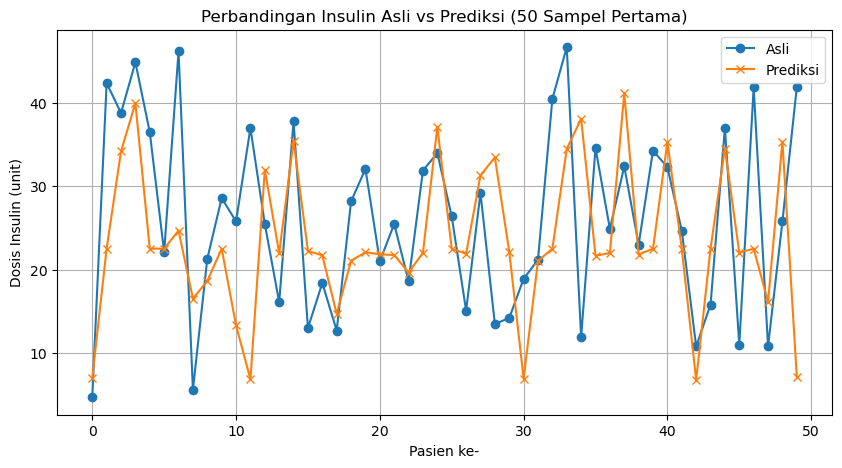

In [38]:
# =====================================================
# 7️⃣ Visualisasi Prediksi vs Data Asli
# =====================================================
plt.figure(figsize=(10,5))
plt.plot(df['InsulinDosage'][:50], label='Asli', marker='o')
plt.plot(df['Predicted_Insulin'][:50], label='Prediksi', marker='x')
plt.title("Perbandingan Insulin Asli vs Prediksi (50 Sampel Pertama)")
plt.xlabel("Pasien ke-")
plt.ylabel("Dosis Insulin (unit)")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\USER\miniconda3\envs\ai_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129656 (\N{DROP OF BLOOD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


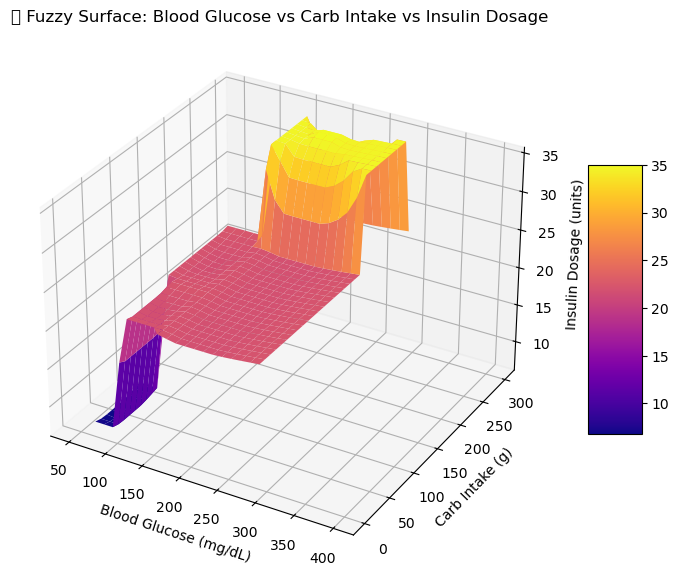

In [39]:
# =====================================================
# 8️⃣ 3D Surface Visualization (BloodGlucose vs CarbIntake)
# =====================================================
x = np.linspace(50, 400, 30)
y = np.linspace(0, 300, 30)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        sim = ctrl.ControlSystemSimulation(insulin_ctrl)
        sim.input['BloodGlucose'] = X[i, j]
        sim.input['CarbIntake'] = Y[i, j]
        sim.input['Age'] = 40
        sim.input['Weight'] = 70
        try:
            sim.compute()
            Z[i, j] = sim.output.get('InsulinDosage', np.nan)
        except:
            Z[i, j] = np.nan

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none')
ax.set_xlabel("Blood Glucose (mg/dL)")
ax.set_ylabel("Carb Intake (g)")
ax.set_zlabel("Insulin Dosage (units)")
ax.set_title("🩸 Fuzzy Surface: Blood Glucose vs Carb Intake vs Insulin Dosage")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [40]:
# =====================================================
# 9️⃣ Simulasi Kasus Manual
# =====================================================
data_uji = [
    {'BloodGlucose': 120, 'CarbIntake': 80, 'Age': 25, 'Weight': 60},
    {'BloodGlucose': 200, 'CarbIntake': 150, 'Age': 40, 'Weight': 70},
    {'BloodGlucose': 150, 'CarbIntake': 200, 'Age': 55, 'Weight': 80},
]

for case in data_uji:
    sim = ctrl.ControlSystemSimulation(insulin_ctrl)
    sim.input['BloodGlucose'] = case['BloodGlucose']
    sim.input['CarbIntake'] = case['CarbIntake']
    sim.input['Age'] = case['Age']
    sim.input['Weight'] = case['Weight']
    
    sim.compute()
    hasil = sim.output.get('InsulinDosage', np.nan)
    print(f"Gula {case['BloodGlucose']} mg/dL | Karbo {case['CarbIntake']} g → 💉 Prediksi Insulin: {round(hasil,2)} unit")


Gula 120 mg/dL | Karbo 80 g → 💉 Prediksi Insulin: 22.11 unit
Gula 200 mg/dL | Karbo 150 g → 💉 Prediksi Insulin: 21.81 unit
Gula 150 mg/dL | Karbo 200 g → 💉 Prediksi Insulin: 22.16 unit
